In [2]:
import pandas as pd
from pathlib import Path

In [26]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/sp_para entrenar/'
pathlist = Path(path).glob('*.csv')
sparks_data_list = []
for file in pathlist:
    path_in_str = str(file)
    df = pd.read_csv(path_in_str)
    sparks_data_list.append(df)
sparks_data_list = pd.concat(sparks_data_list)
del (sparks_data_list['Unnamed: 0'])
del (sparks_data_list['minim'])
del (sparks_data_list['FWHM'])
# del (sparks_data_list['pos_x'])
# del (sparks_data_list['pos_y'])

In [27]:
sparks_data_list.head()

,tiempo_maximo,intensidad_maxima,tiempo_minimo,intensidad_minima,tiempo_valle,intensidad_valle,sparks_amplitud,TTP,sparks_tiempo_pico50,sparks_tiempo_pico50_2,...,TTP50,FDHM,fullWidth,(ΔF/F0)/ΔTmax,fullDuration,pos_x,pos_y,width,high,flag
0,13.0,10.925926,5.0,7.740741,23.0,7.666667,0.411483,8.0,9.482171,NaN,...,4.482171,NaN,11.0,0.051435,18.0,71.0,477.0,25.0,27.0,2.0
1,4.0,10.941176,2.0,8.117647,7.0,7.764706,0.347826,2.0,3.206613,NaN,...,1.206613,NaN,12.0,0.173913,5.0,3.0,416.0,12.0,17.0,2.0
2,3.0,7.230769,2.0,6.884615,4.0,6.615385,0.050279,1.0,2.506131,NaN,...,0.506131,NaN,18.0,0.050279,2.0,135.0,386.0,12.0,26.0,1.0
3,15.0,10.363636,1.0,7.454545,0.0,9.636364,0.390244,14.0,12.507874,39.062895,...,11.507874,NaN,2.0,0.027875,-1.0,54.0,382.0,17.0,11.0,2.0
4,24.0,10.689655,11.0,7.931034,26.0,8.229885,0.347826,13.0,19.740930,NaN,...,8.740930,NaN,25.0,0.026756,15.0,50.0,379.0,41.0,87.0,2.0


In [15]:
#Disabling the warnings permantently
import warnings
warnings.filterwarnings('ignore')

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


from sklearn.model_selection import (RandomizedSearchCV,
                                     KFold,
                                     cross_val_score,
                                     train_test_split)
from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)

from xgboost import XGBClassifier

In [17]:
sparks_data_list.isnull().sum()

tiempo_maximo               61
intensidad_maxima           61
tiempo_minimo               61
intensidad_minima           61
tiempo_valle                61
intensidad_valle            61
sparks_amplitud             61
TTP                         61
sparks_tiempo_pico50        61
sparks_tiempo_pico50_2    2130
sp_tau                     328
full_width                  61
TTP50                       61
FDHM                      2397
fullWidth                   61
(ΔF/F0)/ΔTmax               61
fullDuration                61
width                        0
high                         0
flag                         0
dtype: int64

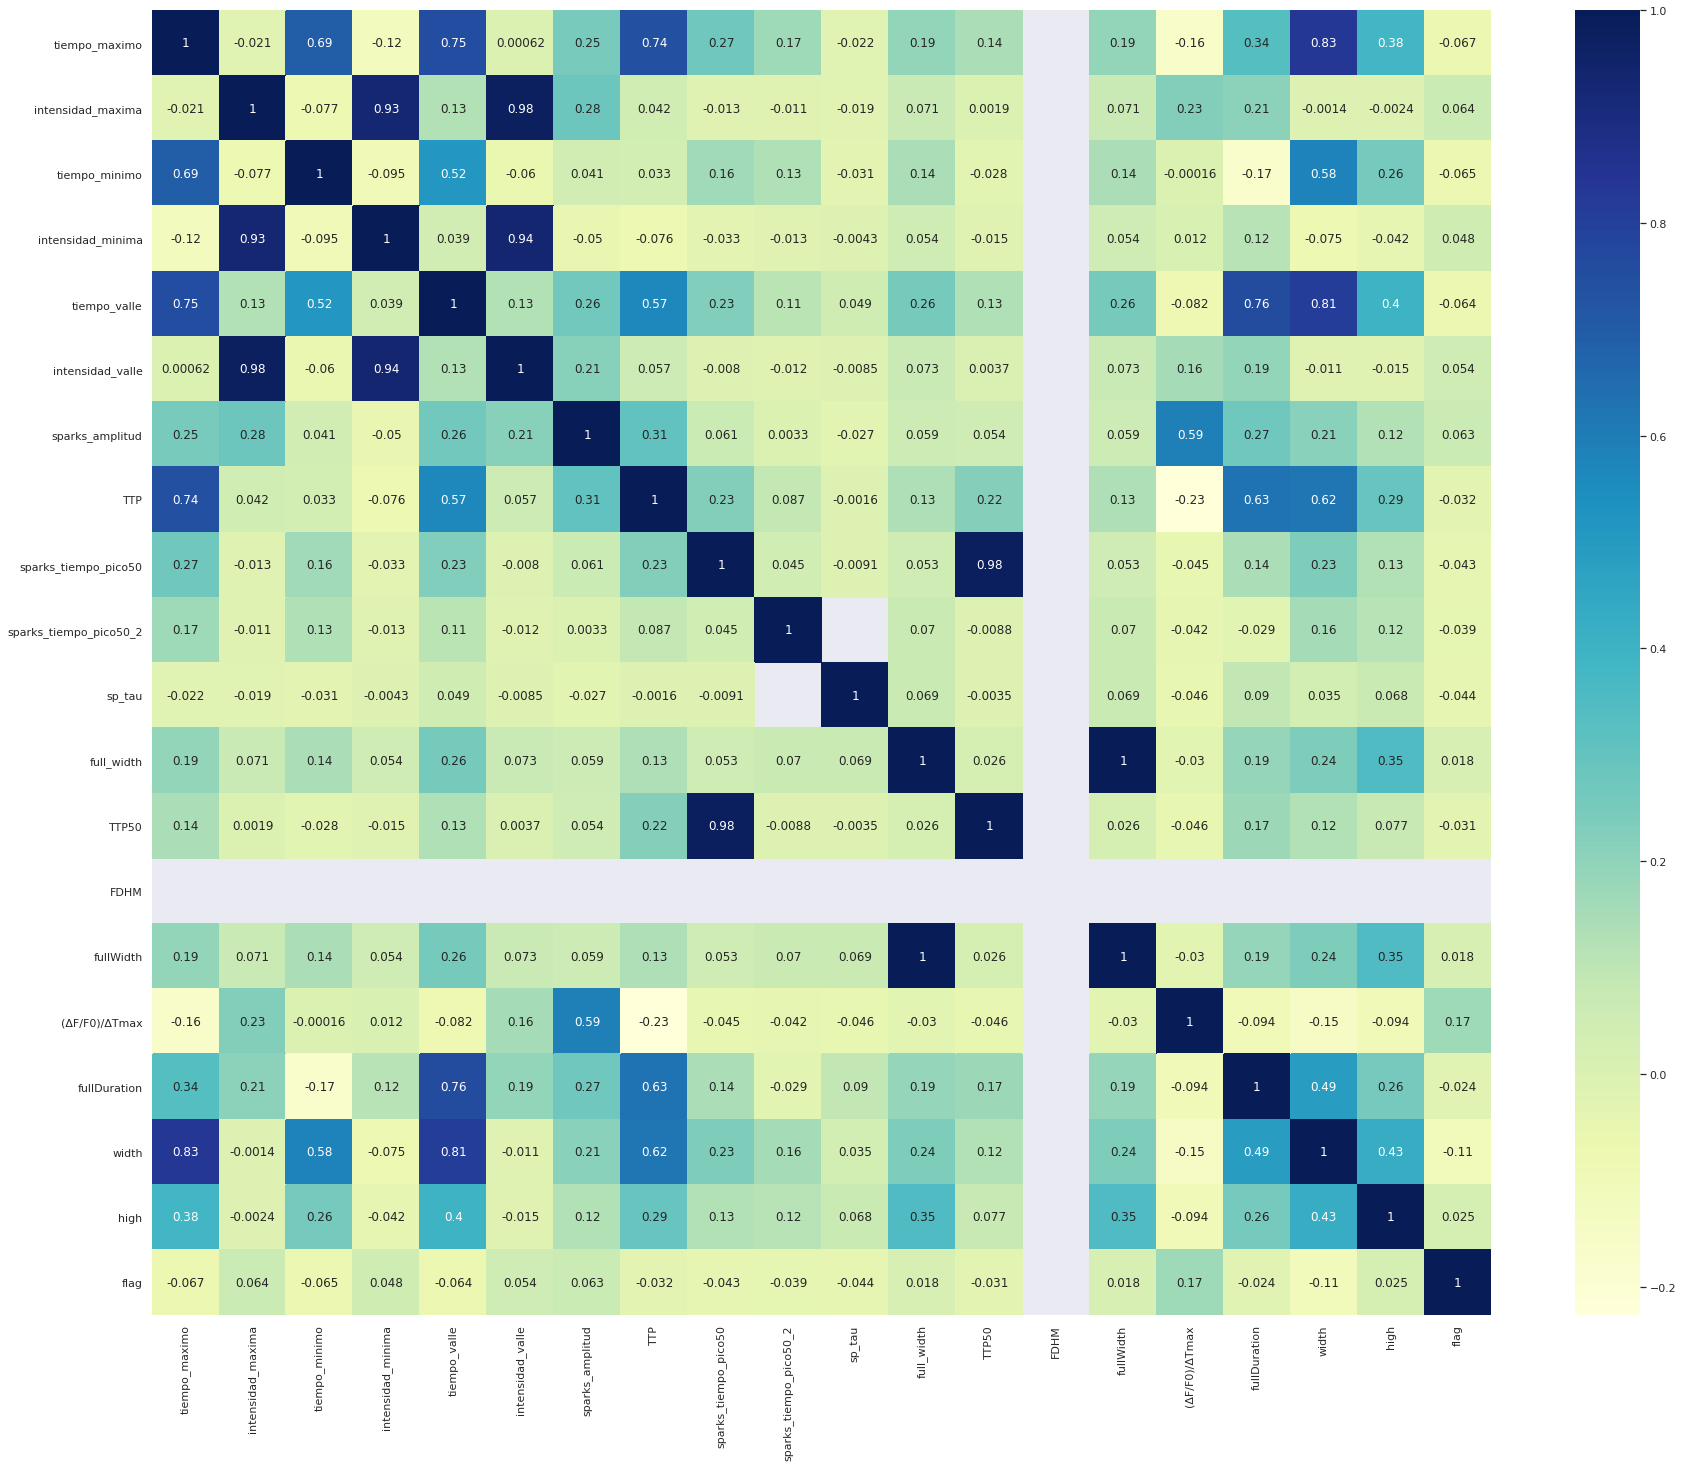

In [18]:
corr = sparks_data_list[sparks_data_list.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(30,24)})

In [19]:
X = sparks_data_list.drop(['flag'], axis=1).values
y = sparks_data_list.flag

In [20]:
X_train,X_test,  y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y)

In [21]:
model_baseline = XGBClassifier()

In [22]:
model_baseline.fit(X_train, y_train)

[01:07:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
def get_prediction(predictions):
    new_preds = []
    for preds in predictions:
        if preds >= 0.25:
            new_preds.append(1)
        else: new_preds.append(0)
    return new_preds

In [24]:
pred_proba_train = model_baseline.predict_proba(X_train)[:, 1]
pred_proba_test = model_baseline.predict_proba(X_test)[:, 1]

pred_train = get_prediction(pred_proba_train)
pred_test = get_prediction(pred_proba_test)

In [25]:
print(f"Train ROC-AUC: {np.round(roc_auc_score(y_train, pred_proba_train), 3)}")
print(f"Test ROC-AUC: {np.round(roc_auc_score(y_test, pred_proba_test), 3)}")

Train ROC-AUC: 1.0
Test ROC-AUC: 0.697
